# TDI Challenge 3

In [219]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
sns.set(style='white', font_scale=1)
import matplotlib.patches as mpatches

from datetime import datetime

import csv

from matplotlib import rcParams

import math
from difflib import SequenceMatcher
from ipywidgets import interact, interactive, fixed, interact_manual
from textwrap import wrap

import sklearn
from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

## Section 3

Propose a project to do while at The Data Incubator. We want to know about **your ability to think at a high level**. Try to think of projects that users or businesses will care about that are also relatively unanalyzed. Here are some useful links about data sources on our blog as well as the archive of data sources on Data is Plural. You can see some final projects of previous Fellows on our YouTube Page.

Propose a project that uses a large, publicly accessible dataset. Explain your motivation for tackling this problem, discuss the data source(s) you are using, and explain the analysis you are performing. At a minimum, you will need to do enough exploratory data analysis to convince someone that the project is viable and generate two interesting non-trivial plots supporting this. The most impressive applicants have even finished a "rough draft" of their projects and have derived non-obvious meaningful conclusions from their data. Explain the plots and give url links to them. For guidance on how to choose a project, check out this blog post.

#### Data:

**Facebook Followers**: Social media platforms like Facebook provide a myriad of data points about companies such as customer traction, foot traffic, and brand awareness among others. This dataset collected the a total number of 3,621,391 historical records of "checkins", "were here count", "talking about count", and "likes" of 4,951 unique business on Facebook.
(source: Thinknum [https://blog.thedataincubator.com/tag/data-sources/])

#### Objectives:

Use social media performace of company to:

Use social media performance of company to:
1. Identify winners in attracting foot traffic within and across multiple industries.
2. Measure the effects of publicized events and marketing campaigns on foot traffic and visibility.

#### Summary of Exploratory Data Analysis:

1. Exploration of the historical (yearly, quarterly, monthly, weekly, daily) trend of "talking about count", "checkin", "likes", and "were here count" of each company. Data visualization through ipywidgets.
2. Matching company name with industry code to provide an industry baseline (computed from the data) to compare when looking at the trend of an individual company.
3. Identified companies of greatest volitatility in "talking about count" and greatest growth in "checkin" within and across industries.
4. Clustering companies by their social media performance (K-Means Clustering). Four clusters of companies are identified.

#### Future Analysis:

1. Better metrics to measures the volatility of "talking about count" and growth of "checkins".
2. More accurate match of company to its industry.
3. More Industry information to establish a better comparison.
4. Predicting the the performance of "checkin" and "talking about count" with the historical data.
5. Predicting the foot traffic and visibility of a company by their social media performance.
6. Measure the effects of publicized events and marketing campaigns on foot traffic and visibility by web scraping publicized events and marketing campaigns information.

------

## Read Data

In [3]:
facebook = pd.read_csv('temp_datalab_records_social_facebook.csv')

/Users/abbypro/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#facebook.dtypes

In [5]:
'Number of Records: {:,}'.format(facebook.shape[0])

'Number of Records: 3,621,391'

In [6]:
'Number of Unique Business: {:,}'.format(len(facebook['username'].unique()))

'Number of Unique Business: 4,951'

In [7]:
# convert string to datatime
facebook['time_2'] = pd.to_datetime(facebook['time'])
facebook['date_updated_2'] = pd.to_datetime(facebook['date_updated'])

----

In [8]:
useful_cols = ['dataset_id','facebook_id', 'username', 
               'checkins', 'were_here_count', 'likes', 'talking_about_count', 
               'time_2','date_updated_2']

In [9]:
num_cols = ['checkins', 'were_here_count', 'likes', 'talking_about_count']

-----

## Trend of Company Social Media Performance
### with Industry Information

### Merge Industry Code

In [10]:
# dataset of firm names and id
cusip = pd.read_csv('cusip.csv')

In [11]:
cusip.shape

(38089, 9)

In [12]:
user_list = facebook['username'].value_counts().index.tolist()

In [13]:
user_list = [u.upper() for u in user_list]

Use SIC to merge.     
Source of SIC:
https://www.sec.gov/info/edgar/siccodes.htm

In [16]:
df_match = pd.DataFrame()
for u in user_list:
    good = cusip['conm'].str.contains(u)
    temp = cusip[good][['conm','gvkey','cusip','sic']]
    temp['user'] = u

    df_match = df_match.append(temp, ignore_index = True) 

In [17]:
df_match.shape

(12767, 5)

In [19]:
# create a new column 'diff' and get the result of comparision to it
df_match['diff'] = df_match[['conm','user']].apply(lambda x: SequenceMatcher(None, x[0].strip(), x[1].strip()).ratio(), axis=1) 

In [20]:
# keep the best match
df_match_good = df_match.sort_values('diff', ascending=False).drop_duplicates(['user'])

In [21]:
df_match_good.shape

(628, 6)

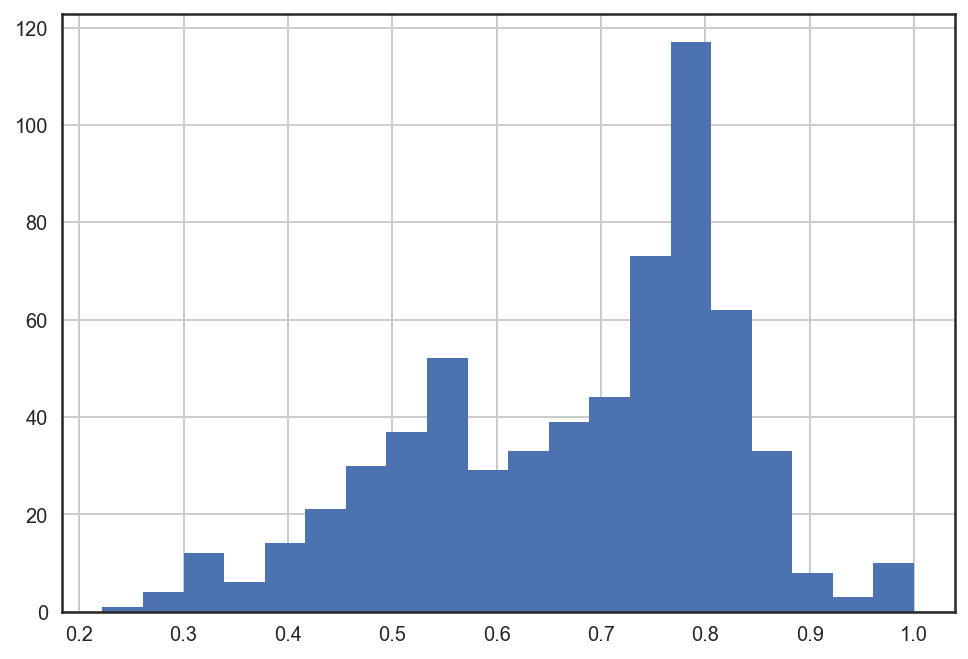

In [24]:
# check the distribution of diff
df_match_good['diff'].hist(bins=20)

In [27]:
sic_2 = pd.read_csv('sic_2_digit_codes.csv')
sic_2.columns = ['sic_2digit','industry_short']

In [29]:
facebook2 = facebook.copy()
facebook2['user'] = facebook2['username'].str.upper()
facebook2 = facebook2[useful_cols+['user']].merge(df_match_good, how = 'left')

In [30]:
facebook2['sic_2digit'] = facebook2['sic'] // 100
facebook2['sic_2digit'] = facebook2['sic_2digit'].fillna(0)
facebook2['sic_2digit'] = facebook2['sic_2digit'].astype('int')
facebook3 = facebook2.merge(sic_2, how = 'left')

In [33]:
facebook3['industry_short'] = facebook3['industry_short'].fillna('Not Available')

In [34]:
#facebook3.columns

In [44]:
#facebook3.to_csv('facebook3.csv',index=False)

In [2]:
#facebook3 = pd.read_csv('facebook3.csv')

In [11]:
#facebook3['time_2'] = pd.to_datetime(facebook3['time_2'])
#facebook3['date_updated_2'] = pd.to_datetime(facebook3['date_updated_2'])

-----

### Industry Baseline

In [35]:
industry_list = facebook3['industry_short'].value_counts().index.tolist()

In [36]:
def get_time_period(df, p):
    '''
    Convert datatime to specific time interval.
    
    df: A Pandas DataFrame.
    p: A string, indicates time interval.
    
    Return a Pandas DataFrame.
    '''
    if p == 'D':
        df['time_period'] = df['time_2'].dt.date
    else:    
        df['time_period'] = df['time_2'].dt.to_period(p)
    
    return df

In [37]:
def industry_baseline(data, industry, col, p):
    '''
    Compute Industry-level metrics.
    
    data: A Pandas DataFrame.
    industry: A string, industry name.
    col: A string, column name.
    p: A string, indicates time interval.
    
    Return a tuple of two Pandas DataFrame.
    
    '''
    
    if industry == 'Not Available':
        return None
    
    good = data['industry_short'] == industry
    df_ind = data[good]
    
    df_ind = get_time_period(df_ind,p)
    
    # calculate the grand mean
    df0 = df_ind.groupby(['time_period','user'])[col].mean()
    df = df0.reset_index().groupby(['time_period'])[col].agg({'mean','median','max','min','std','count'}).reset_index()

    del data
    return df,df0

In [38]:
def company_trend(data, company, col, p):
    '''
    Compute firm-level trend.
    
    data: A Pandas DataFrame.
    company: A string, company name.
    p: A string, indicates time interval.
    
    Return a tuple of Pandas DataFrame and a string. 
    
    '''
    
    good = data['user'] == company
    df = data[good]
    
    industry = df['industry_short'].values[0]
    
    df = get_time_period(df, p)
    
    grouped = df.sort_values('time_period').groupby(['time_period'])
    
    df_byperiod = grouped[col].agg({'mean'}).reset_index()
    
    df_byperiod[col+'_inc'] = df_byperiod['mean'].pct_change()
    df_byperiod = df_byperiod.rename(columns = {'mean': 'avg'})
    
    return df_byperiod, industry

In [39]:
def social_trend(company, interaction, by, 
                 compare = True, 
                 percentage_change = False,
                 data = facebook3):
    '''
    A wrap up function for data visualization.
    
    company: A string, company name.
    interaction: A string, specify which type of online activities to look at.
    by: A string, indicates time interval.
    compare: A Bool, whether to compare the company with its identified industry. Default True.
    percentage_change: A Bool, whether to show percentage change of certain trend. Default False.
    data: A Pandas DataFrame. Default value 'facebook3'.
    
    Return None.
    '''

    period = {'Day': 'D',
          'Week': 'W',
          'Quarter': 'Q',
          'Month': 'M',
          'Year': 'A'}
    
    cols = {'Were-Here': 'were_here_count',
            'Check-Ins': 'checkins',
            'Likes': 'likes',
            'Talking-About':'talking_about_count'}
    
    col = cols.get(interaction)
    p = period.get(by)
    
    df_plot, industry = company_trend(data,company,col,p)
    df_plot['t'] = df_plot.index
    
    fig, ax = plt.subplots(figsize = (15,6))

    if compare and industry != 'Not Available':
        
        df_ind,_ = industry_baseline(data,industry,col,p)
        df_plot = df_plot.merge(df_ind,how = 'left',on='time_period')

        ax.plot(df_plot['t'],df_plot['mean'],lw=2, label='Industry Baseline: {}'.format(industry), color='yellow')
        ax.plot(df_plot['t'],df_plot['avg'],lw=2.5, label=company, color='black')
        ax.fill_between(df_plot['t'],df_plot['mean']-df_plot['std'],df_plot['mean']+df_plot['std'], 
                        facecolor='yellow', label='Industry Mean +/- sd', alpha=0.2)
        ax.fill_between(df_plot['t'],df_plot['min'],df_plot['max'], 
                        facecolor='blue',label='Industry Minimum and Maximum', alpha=0.1)
        ax.legend(loc='upper left')
        ax.set_title("Trend of {0}: {1} (Industry: {2})".format(interaction, company,industry))
        ax.set_ylabel("Counts")
    
    elif percentage_change:

        baseline = 0
        temp = df_plot[col+'_inc'].values.tolist()
        temp.pop(0)

        ax.bar(range(len(temp)), temp, bottom=baseline)

        ax.set_title("Percentage Change of {0}: {1} (Industry: {2})".format(interaction, company,industry))
        ax.set_ylabel("Percentage")
        
    else:
        ax.plot(df_plot['t'],df_plot['avg'],lw=2.5, label=company, color='black')
        ax.set_title("Trend of {0}: {1} (Industry: {2})".format(interaction, company,industry))
        ax.set_ylabel("Counts")

    ax.set_xlabel(by)
    freq = len(df_plot['t'].values.tolist())//20 + 1
    ax.set_xticks(df_plot['t'].values.tolist()[::freq])
    ax.set_xticklabels(df_plot['time_period'].values.tolist()[::freq], rotation=45)
    sns.despine()

### ipywidgets: Allow interactively selecting company, interaction type, and time interval to look a trend
(became static when uploaded to github)

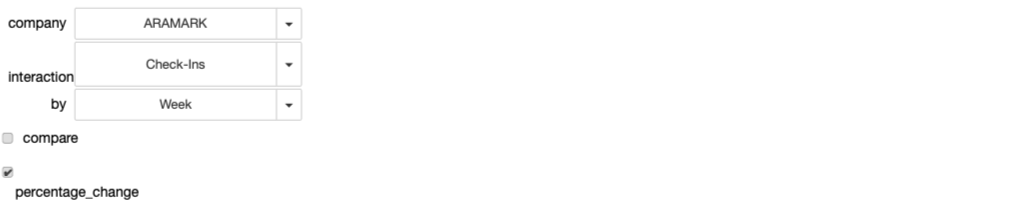

/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


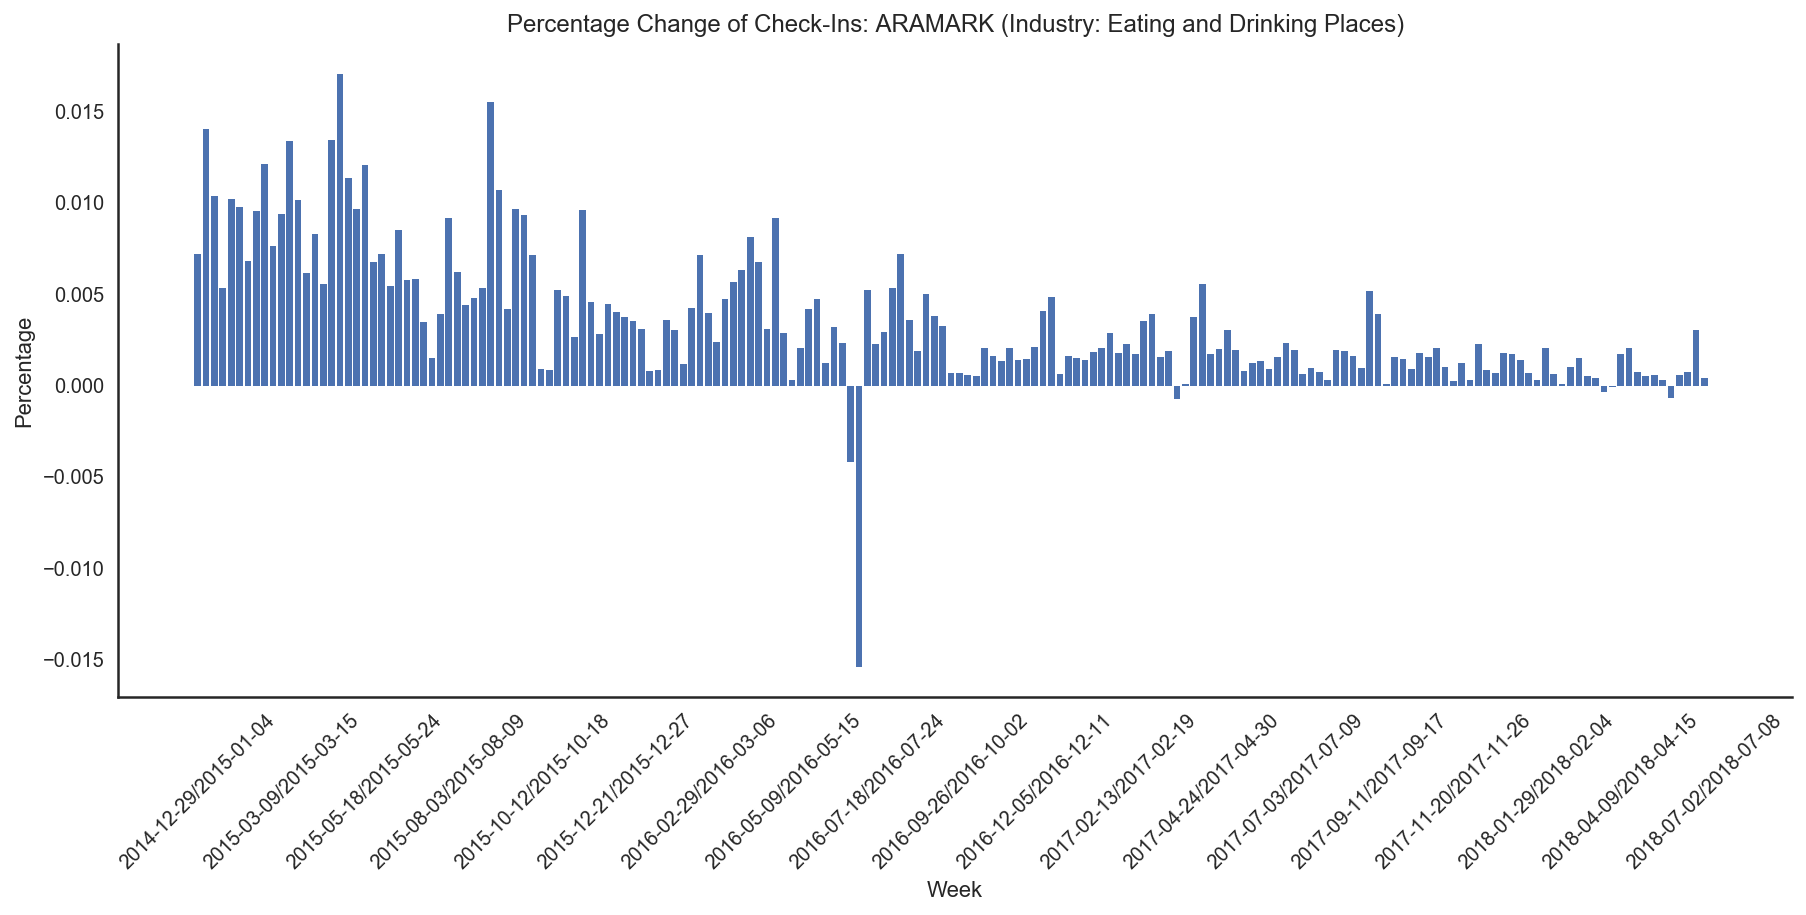

In [40]:
user_list_temp = facebook3['user'].value_counts().sort_index().index.tolist()
interact(social_trend, 
                    company = user_list_temp,
                    interaction = ['Talking-About','Check-Ins','Likes','Were-Here'],
                    by = ['Week','Day','Month','Quarter','Year'],
                    compare = False,
                    percentage_change = False,
                    data = fixed(facebook3))

------

### Focus on Some Industries

In [41]:
focus_industry = ['Business Services',
 'Communications',
 'Miscellaneous Retail',
 'Food and Kindred Products',
 'Eating and Drinking Places',
 'Apparel, Finished Products from Fabrics & Similar Materials',
 'Apparel and Accessory Stores',
 'Insurance Carriers',
 'Food Stores',
 'Wholesale Trade - Nondurable Goods',
 'Transportation Services',
 'Real Estate',
 'Hotels, Rooming Houses, Camps, and Other Lodging Places',
 'Transportation by Air',
 'Motion Pictures',
 'Health Services',
 'Amusement and Recreation Services']

In [42]:
good = facebook3['industry_short'].isin(focus_industry)
facebook4 = facebook3[good]

In [43]:
facebook4.shape

(253402, 17)

### ipywidgets: Allow interactively selecting company, interaction type, and time interval to look at a trend
(became static when uploaded to github)

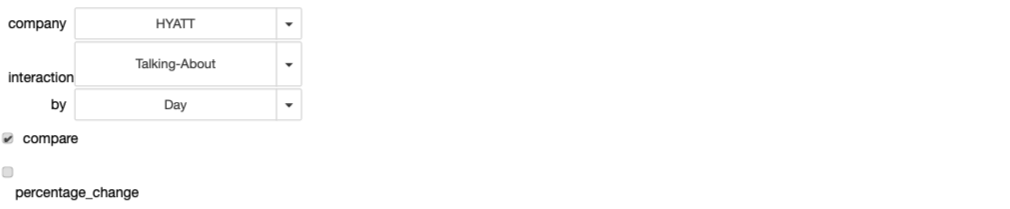

/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


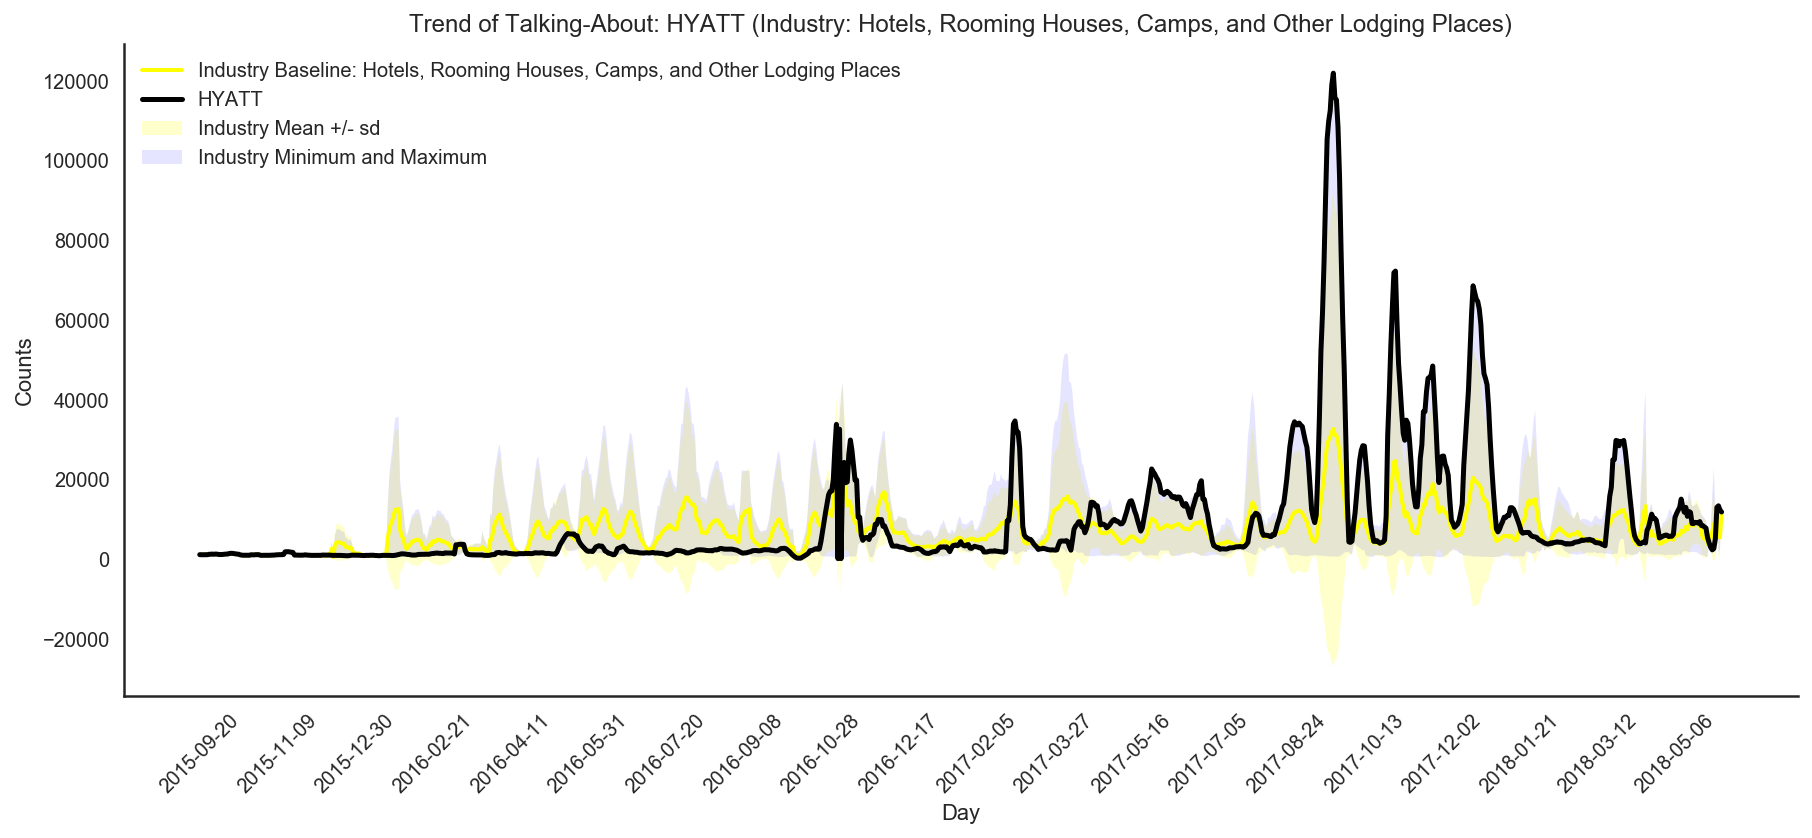

In [45]:
user_list_temp = facebook4['user'].value_counts().sort_index().index.tolist()
interact(social_trend, 
                    company = user_list_temp,
                    interaction = ['Talking-About','Check-Ins','Likes','Were-Here'],
                    by = ['Week','Day','Month','Quarter','Year'],
                    compare = False,
                    percentage_change = False,
                    data = fixed(facebook4))

------

## Looking at Volatility and Growth of Social Media Performance
#### Coefficient of Variance, Percentage Change and Other Statistics

In [46]:
def company_summary(df,p):
    
    '''
    Compute firm level statistics
    
    df: A Pandas DataFrame.
    p: A string, indicates time interval.
    
    Return a tuple of Pandas DataFrame and a string. 
    '''
    
    df = get_time_period(df, p)

    # group by user and time period
    df_bytime = df.groupby(['user','time_period'])[num_cols].mean()
    
    # calculate grand mean and other statistics
    df_stats = df_bytime.reset_index().groupby(['user'])[num_cols].agg({'mean','max','std','count'}).reset_index()
    df_stats.columns = df_stats.columns.map('{0[0]}_{0[1]}'.format) 
    df_stats = df_stats.rename(columns = {'user_':'user'})
    
    # volatility: (Coefficient of Variance)COV
    df_cov = df_bytime.reset_index().groupby(['user'])[num_cols].apply(lambda x: x.std()/x.mean()).reset_index()
    df_cov = df_cov.rename(columns = {'checkins': 'checkins_cov',
                                      'were_here_count':'were_here_count_cov',
                                      'likes':'likes_cov',
                                      'talking_about_count':'talking_about_count_cov'})
    # merge two datasets
    df_merge = df_cov.merge(df_stats)
    
    # percentage change: total percentage change 
    df_percent = df_bytime.reset_index()
    colnames = [col+'_inc' for col in num_cols]
    df_percent[colnames] = df_percent.sort_values('time_period').groupby(['user'])[num_cols].pct_change()
    df_percent_sum = df_percent.groupby(['user'])[colnames].sum().reset_index()
    
    # merge two datasets
    df_merge = df_merge.merge(df_percent_sum)
    
    return df_merge, df_bytime

In [47]:
# get statistics at daily level
df_stats, df_bytime = company_summary(facebook3,'D')

In [48]:
df_stats.shape

(4891, 25)

In [ ]:
user_industry = facebook3.sort_values('user').drop_duplicates('user')[['user','sic','industry_short']]

In [ ]:
df_stats = df_stats.merge(user_industry)

In [132]:
df_stats = df_stats.replace([np.inf, -np.inf], np.nan)

In [ ]:
df.set_index('user', inplace = True)

------

### Volatility of Four Activities

--------------------------------------------------------------------------------
Talking-About: Most Volatile Company: FORTRESSBIOTECH
Talking-About: Least Volatile Company: NTELOSWIRELESS
--------------------------------------------------------------------------------
Check-Ins: Most Volatile Company: SEALYMATTRESS
Check-Ins: Least Volatile Company: 105.7WROR
--------------------------------------------------------------------------------
Likes: Most Volatile Company: FORTRESSBIOTECH
Likes: Least Volatile Company: ALLIEDHPI
--------------------------------------------------------------------------------
Were-Here: Most Volatile Company: UNITIL
Were-Here: Least Volatile Company: ABEONABIO


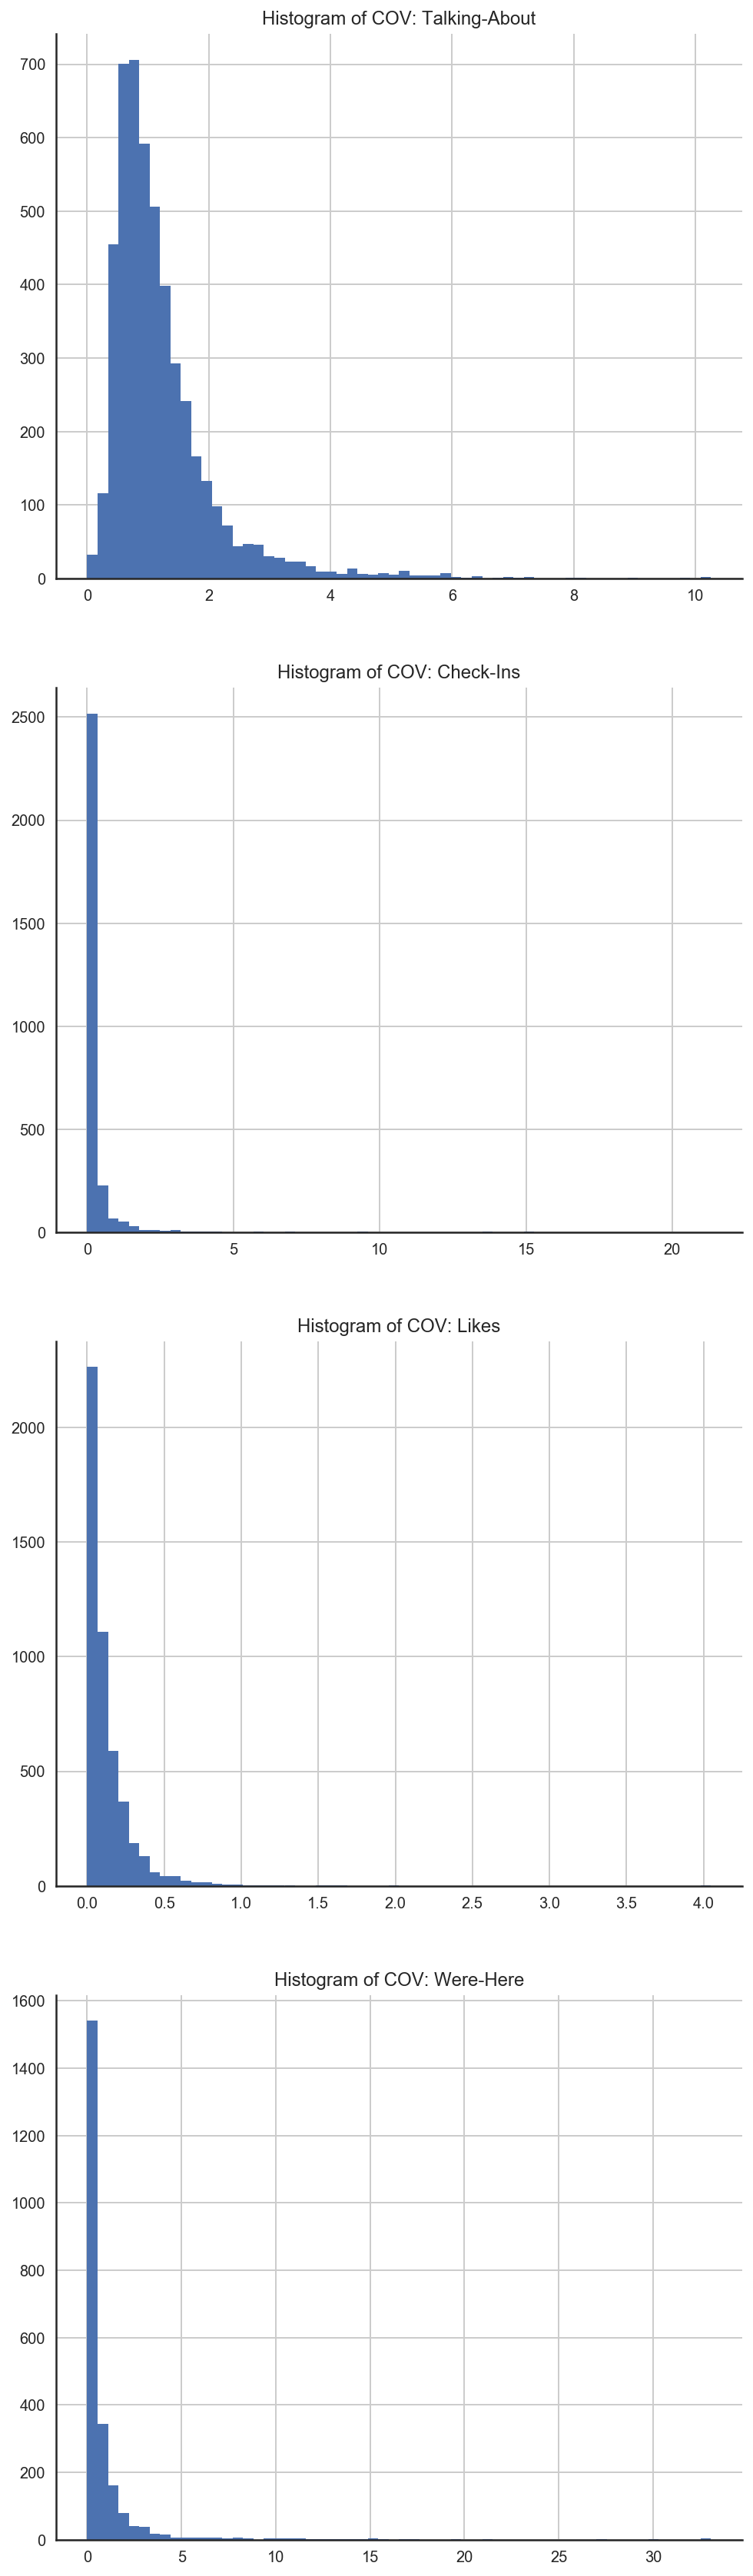

In [134]:
## Look at 

data = df_stats.copy()

cols = {'Were-Here': 'were_here_count',
            'Check-Ins': 'checkins',
            'Likes': 'likes',
            'Talking-About':'talking_about_count'}
interaction = ['Talking-About','Check-Ins','Likes','Were-Here']

fig = plt.figure(figsize = (8,30))
idx = 1
for i in interaction:
    col = cols.get(i)+'_cov'
    string1 = '{0}: Most Volatile Company: {1}'.format(i,data[col].idxmax())
    string2 = '{0}: Least Volatile Company: {1}'.format(i,data[col].idxmin())
    print('--'*40)
    print(string1)
    print(string2)

    ax = fig.add_subplot(4, 1, idx)
    ax = data[col].hist(bins=60)
    ax.set_title('Histogram of COV: {0}'.format(i))
    sns.despine()
    idx = idx + 1
    
del data

### Growth of Four Activities

--------------------------------------------------------------------------------
Talking-About: Most Increased Company: SISTERSCHUBERTS
Talking-About: Least Increased Company: NAPWHQ
--------------------------------------------------------------------------------
Check-Ins: Most Increased Company: BOYDGAMING
Check-Ins: Least Increased Company: DUNKINDONUTS
--------------------------------------------------------------------------------
Likes: Most Increased Company: CONCENTRIXJAPAN
Likes: Least Increased Company: BLACKBERRY
--------------------------------------------------------------------------------
Were-Here: Most Increased Company: SPPLUSCORP
Were-Here: Least Increased Company: ORIONGAZETTE


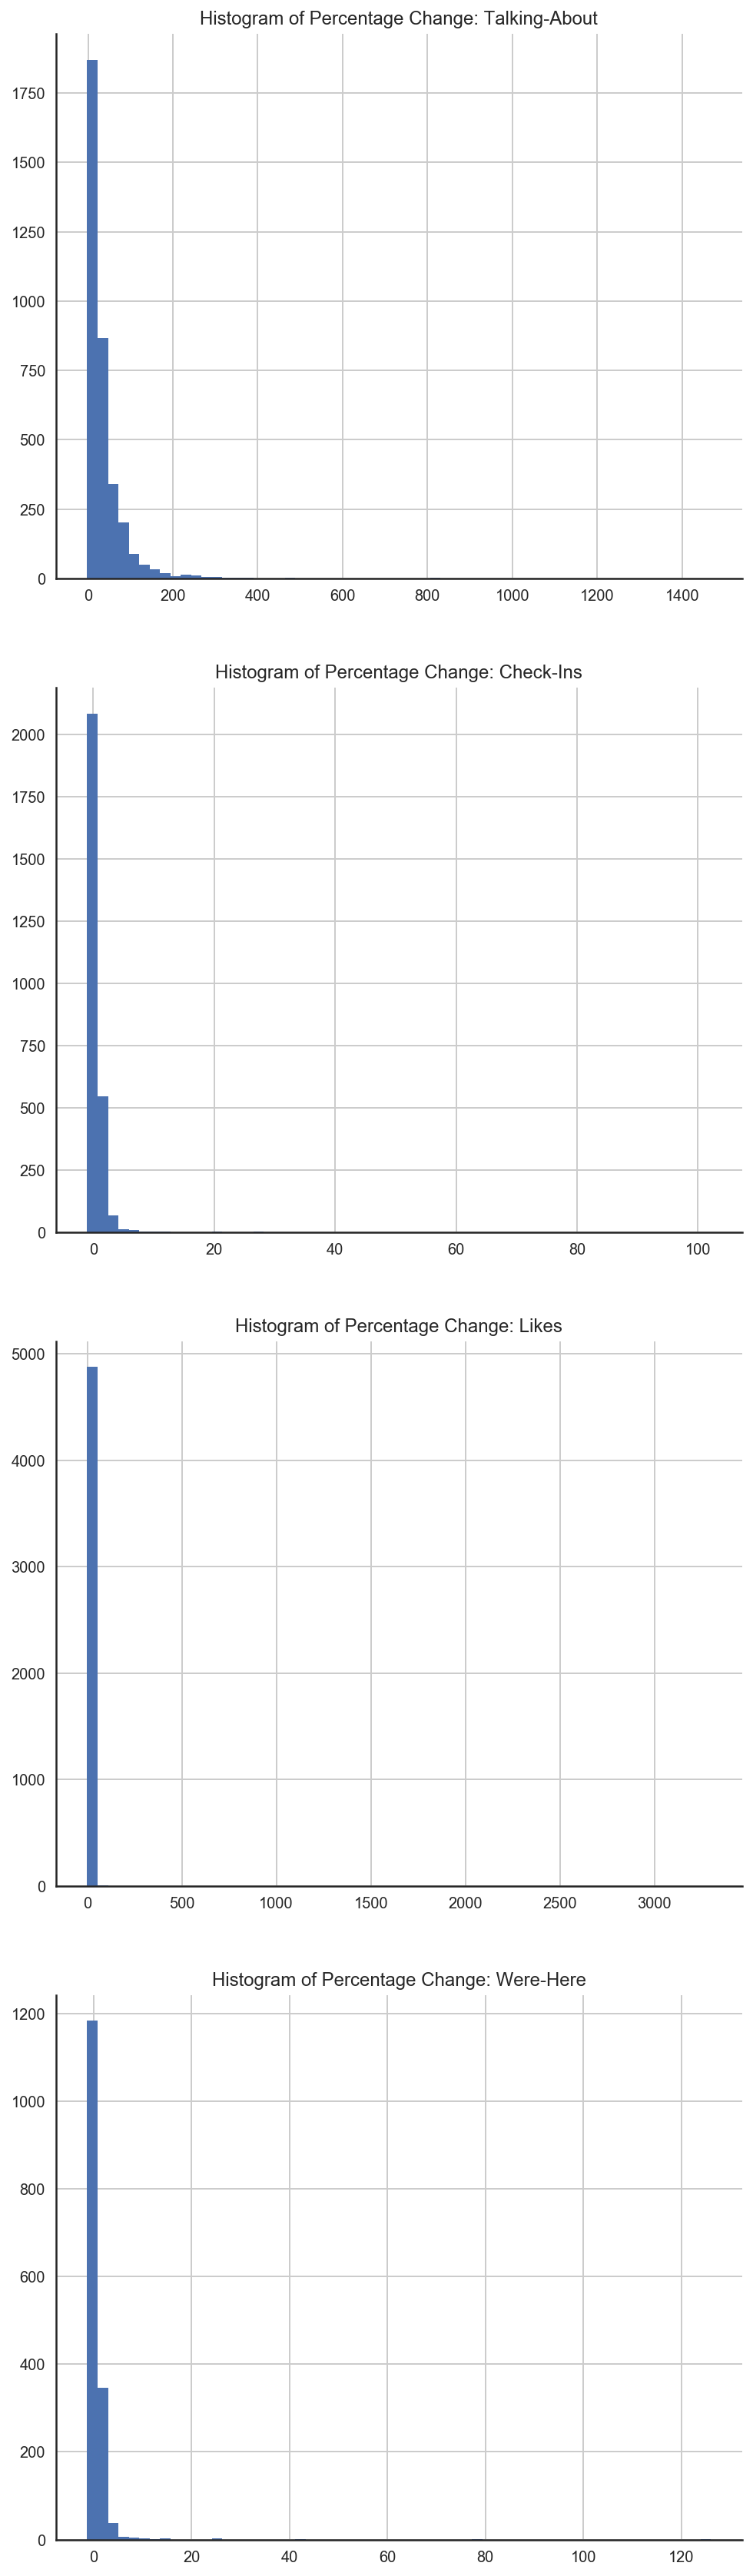

In [135]:
data = df_stats.copy()

cols = {'Were-Here': 'were_here_count',
            'Check-Ins': 'checkins',
            'Likes': 'likes',
            'Talking-About':'talking_about_count'}
interaction = ['Talking-About','Check-Ins','Likes','Were-Here']

fig = plt.figure(figsize = (8,30))
idx = 1
for i in interaction:
    col = cols.get(i)+'_inc'
    string1 = '{0}: Most Increased Company: {1}'.format(i,data[col].idxmax())
    string2 = '{0}: Least Increased Company: {1}'.format(i,data[col].idxmin())
    print('--'*40)
    print(string1)
    print(string2)

    ax = fig.add_subplot(4, 1, idx)
    data[col].replace([np.inf, -np.inf], np.nan, inplace = True)
    ax = data[col].hist(bins=60)
    ax.set_title('Histogram of Percentage Change: {0}'.format(i))
    sns.despine()
    idx = idx + 1
    
del data

------

### Winner Companies

In [231]:
#focus_industry

In [136]:
good = df_stats['industry_short'].isin(focus_industry)
top50_vol = df_stats[good]['talking_about_count_cov'].sort_values(ascending = False)[0:50]

In [142]:
df_top50_vol = df_stats.loc[top50_vol.index,['industry_short','talking_about_count_cov']]

In [138]:
top50_inc = df_stats[good]['checkins_inc'].sort_values(ascending = False)[0:50]

In [143]:
df_top50_inc = df_stats.loc[top50_inc.index,['industry_short','checkins_inc']]

In [226]:
cmap = plt.cm.tab20
colors = {}
for idx, ind in enumerate(focus_industry):
    colors[ind] = rgb2hex(cmap(idx))

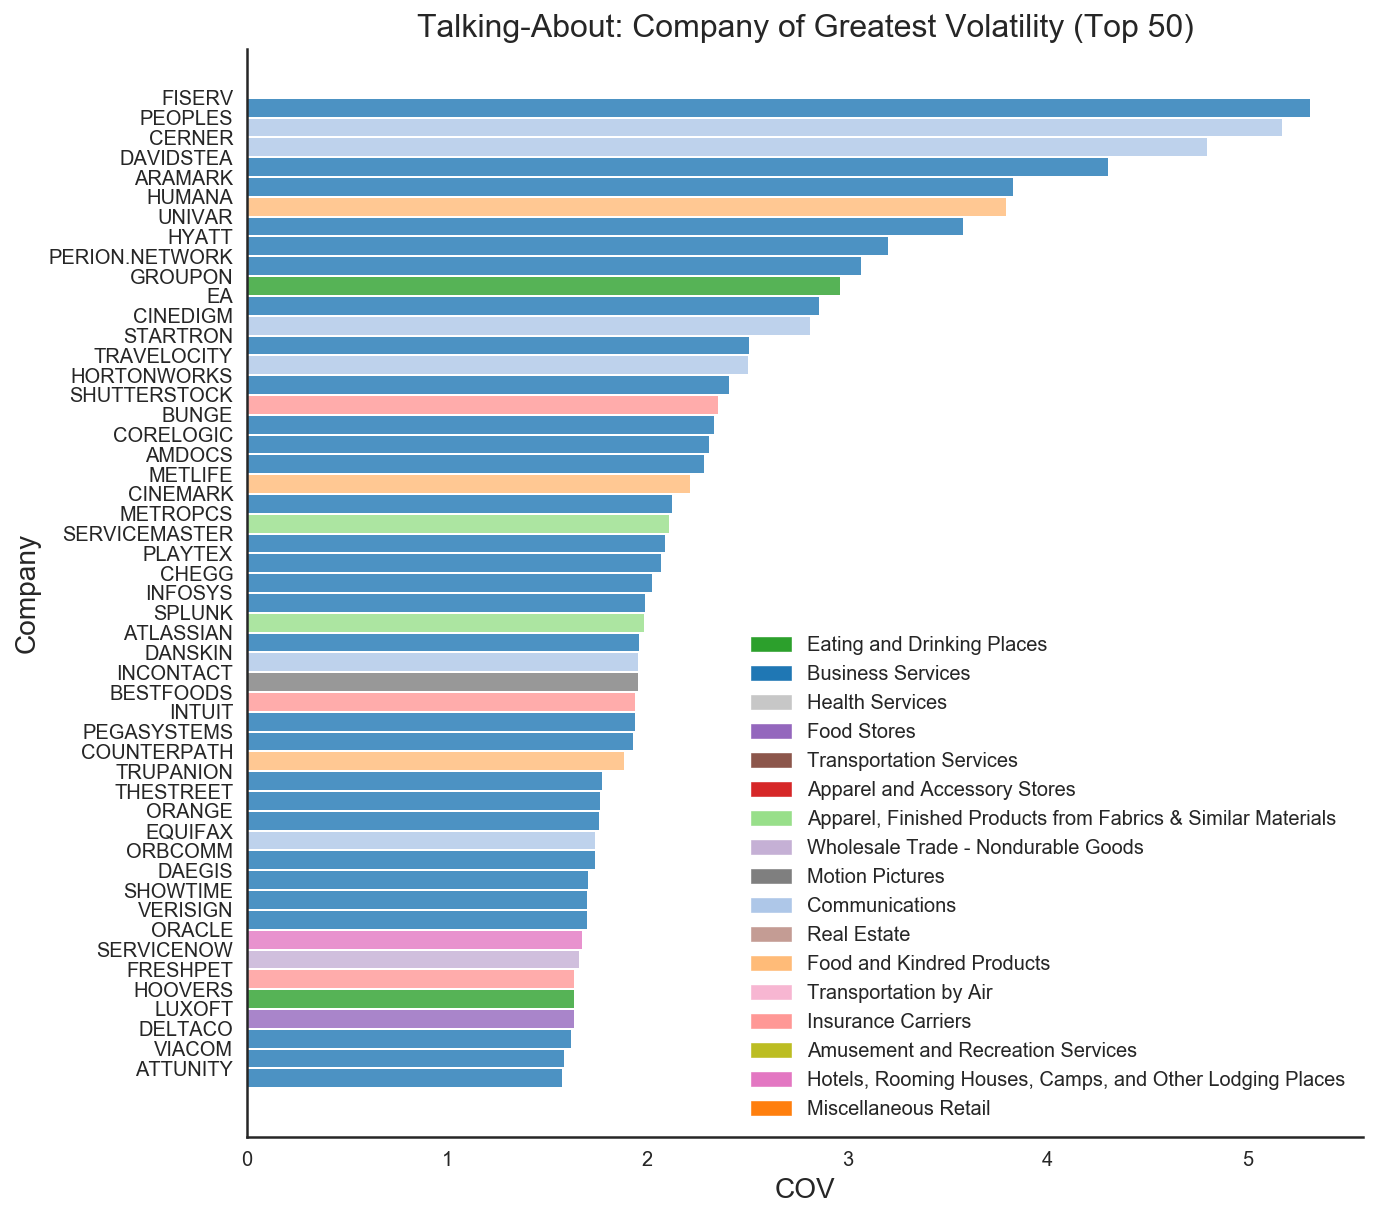

In [228]:
# visualization

fig, ax = plt.subplots(figsize = (10,10))
x = df_top50_vol['talking_about_count_cov'][::-1]
N = len(x)
y = list(range(N))
y_ticks = [i+0.5 for i in y]
ind = df_top50_vol['industry_short'][::-1].values.tolist()
ind_colors = [colors[i] for i in ind]

ax.barh(y,x,
        color = ind_colors, height = 0.9, alpha = 0.8)
ax.set_yticks(y_ticks)
ax.set_yticklabels(df_top50_vol.index.tolist())
ax.set_title('Talking-About: Company of Greatest Volatility (Top 50)', fontsize = 16)
ax.set_ylabel('Company',fontsize = 14)
ax.set_xlabel('COV', fontsize = 14)
handle = []
for key, value in colors.items():
    p = mpatches.Patch(color=value, label=key)
    handle.append(p)
plt.legend(handles=handle, loc=4)
sns.despine()

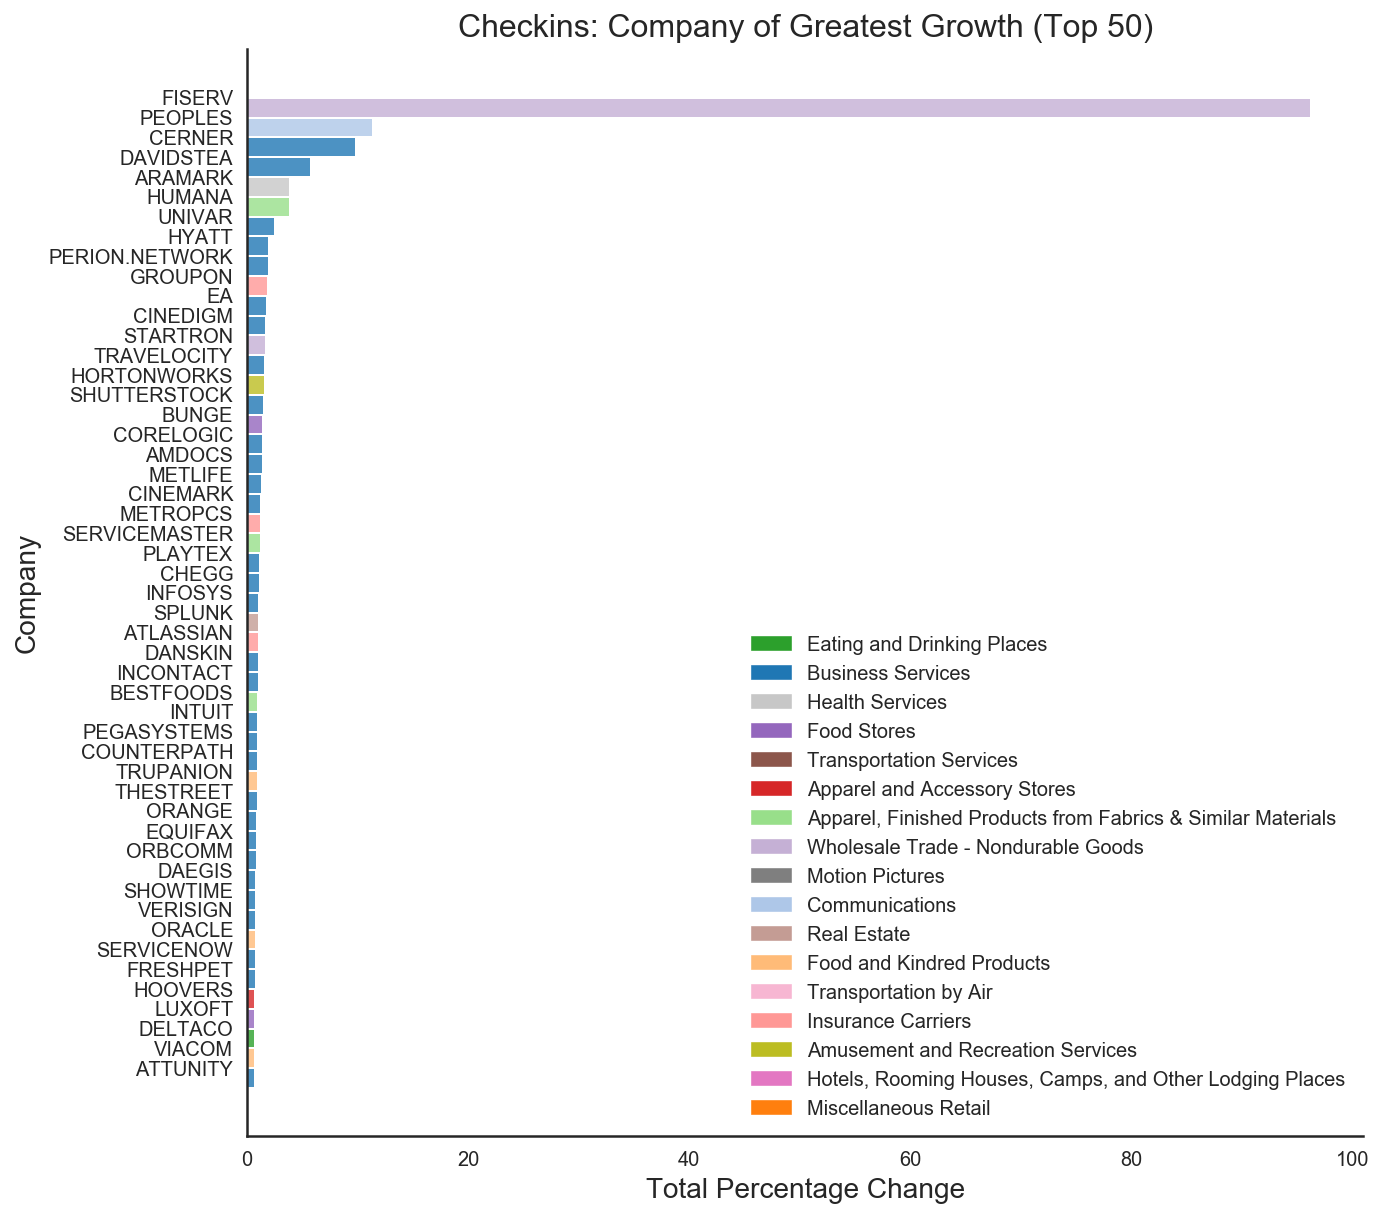

In [232]:
# visualization

fig, ax = plt.subplots(figsize = (10,10))
x = df_top50_inc['checkins_inc'][::-1]
N = len(x)
y = list(range(N))
y_ticks = [i+0.5 for i in y]
ind = df_top50_inc['industry_short'][::-1].values.tolist()
ind_colors = [colors[i] for i in ind]

ax.barh(y,x,
        color = ind_colors, height = 0.9, alpha = 0.8)
ax.set_yticks(y_ticks)
ax.set_yticklabels(df_top50_vol.index.tolist())
ax.set_title('Checkins: Company of Greatest Growth (Top 50)', fontsize = 16)
ax.set_ylabel('Company',fontsize = 14)
ax.set_xlabel('Total Percentage Change', fontsize = 14)

handle = []
for key, value in colors.items():
    p = mpatches.Patch(color=value, label=key)
    handle.append(p)
plt.legend(handles=handle, loc=4)
sns.despine()

------

### Winner Companies in Each Industry

In [57]:
notime_cols = ['dataset_id', 'facebook_id', 'username','user',
       'conm', 'gvkey', 'cusip', 'sic', 'diff',
       'sic_2digit', 'industry_short']

In [58]:
df_notime = facebook3[notime_cols].drop_duplicates('user')

In [60]:
df_notime = df_notime.merge(df_stats)

In [65]:
df_notime.set_index('user',inplace = True)

In [66]:
df_cov = df_notime.groupby(['industry_short'])['talking_about_count_cov'].agg({'max','idxmax'}).reset_index()

In [67]:
good = df_cov['industry_short'].isin(focus_industry)
df_cov_f = df_cov[good].sort_values('max', ascending = False)

In [69]:
df_cov_f.set_index('industry_short', inplace = True)

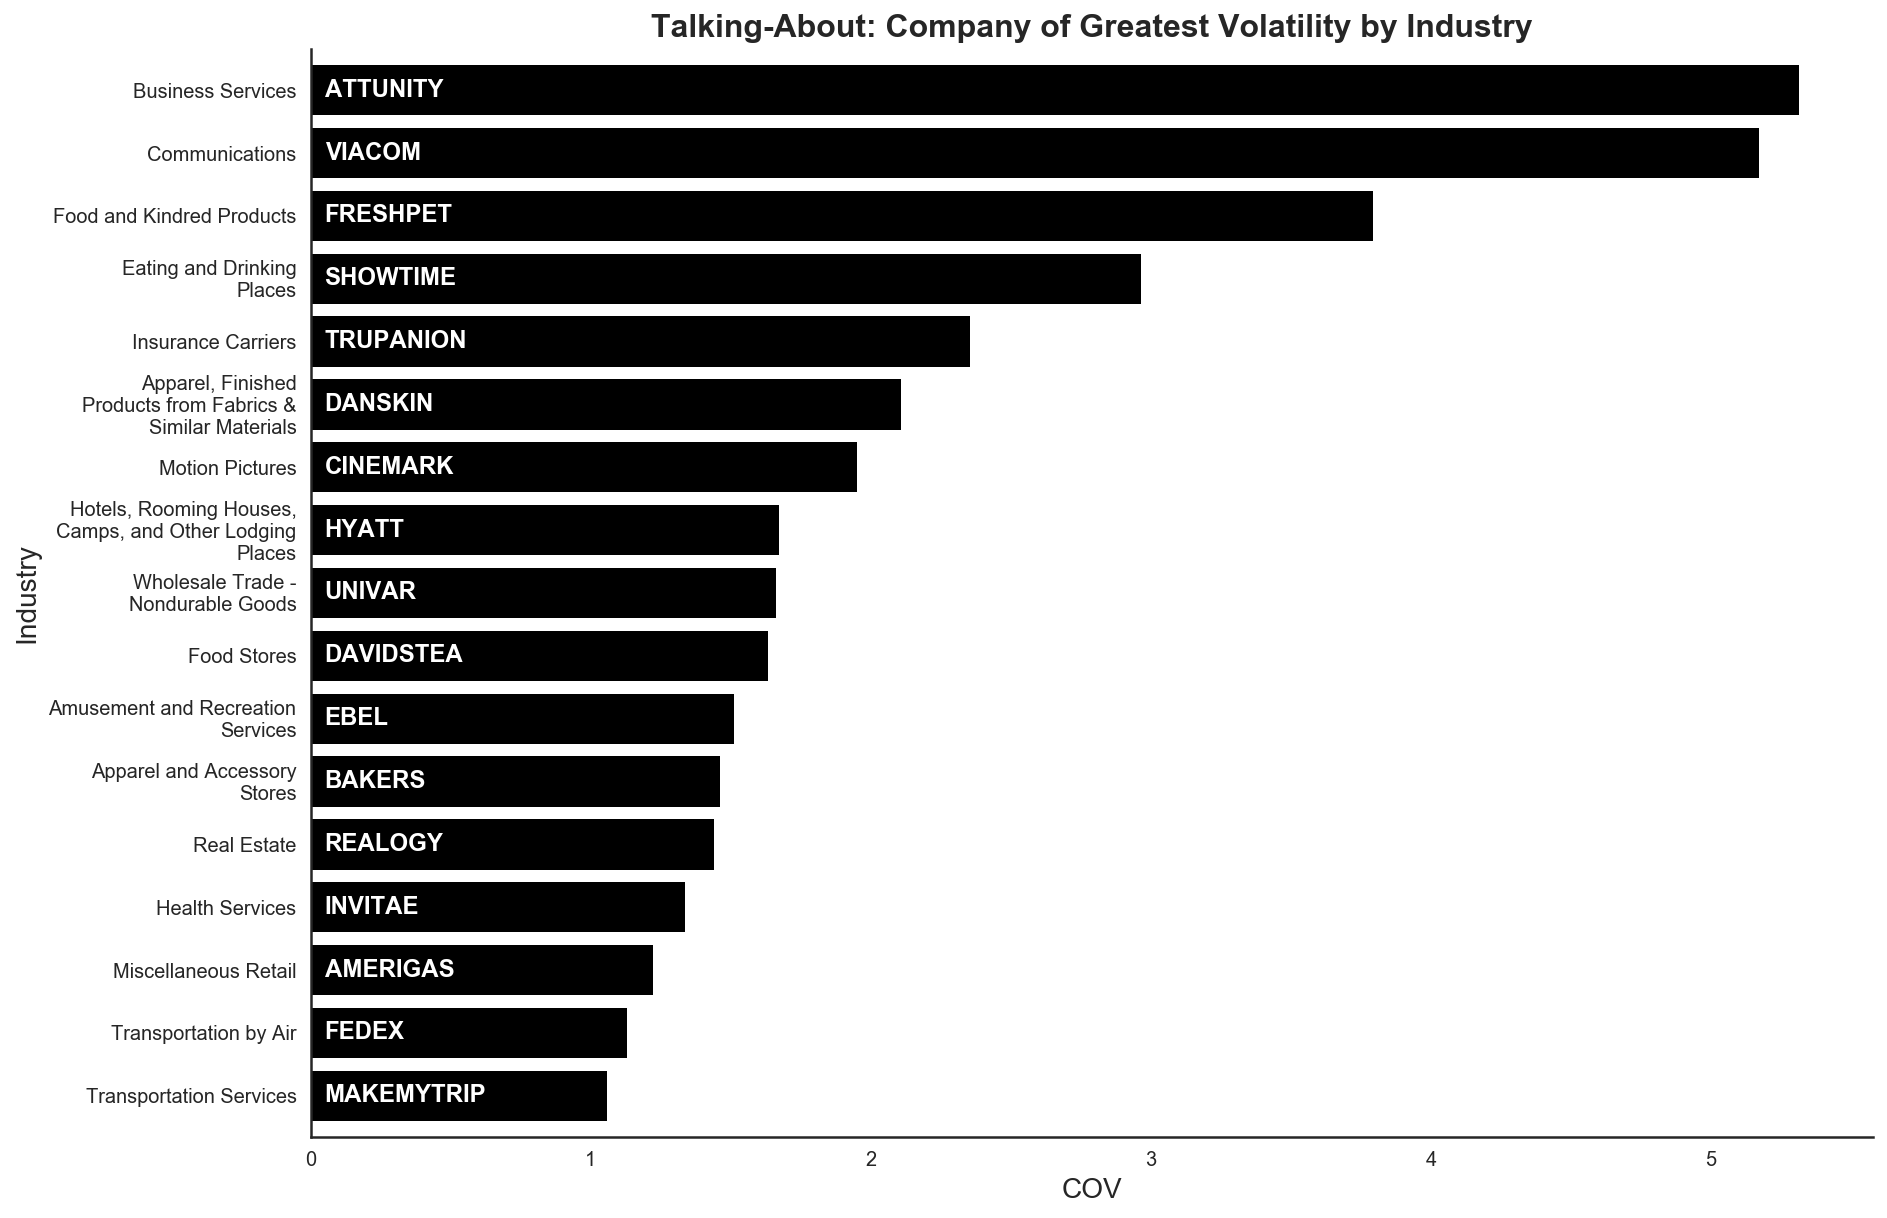

In [101]:
# visualization

bardata = df_cov_f['max'][::-1]
labels = df_cov_f['idxmax'][::-1].values.tolist()
yticks = df_cov_f.index[::-1].tolist()
yticks = [ '\n'.join(wrap(l, 25)) for l in  yticks]

fig, ax = plt.subplots(figsize=(14,10))
bardata.plot.barh(color = 'black', width = 0.8)
plt.title("Talking-About: Company of Greatest Volatility by Industry", fontsize = 16, fontweight='bold')
plt.ylabel("Industry", fontsize = 14)
plt.xlabel("COV",fontsize = 14)

ax.set_yticklabels(yticks)

for i, v in enumerate(labels):
    plt.text(0.05,i, labels[i], color='white', va='center', fontweight='bold')
sns.despine()

In [78]:
col = 'checkins'
df_notime[col+'_inc'].replace([np.inf, -np.inf], np.nan, inplace = True)
df_inc = df_notime.groupby(['industry_short'])[col+'_inc'].agg({'max','idxmax'}).reset_index()

In [79]:
good = df_inc['industry_short'].isin(focus_industry)
df_inc_f = df_inc[good].sort_values('max', ascending = False)
df_inc_f.set_index('industry_short', inplace = True)

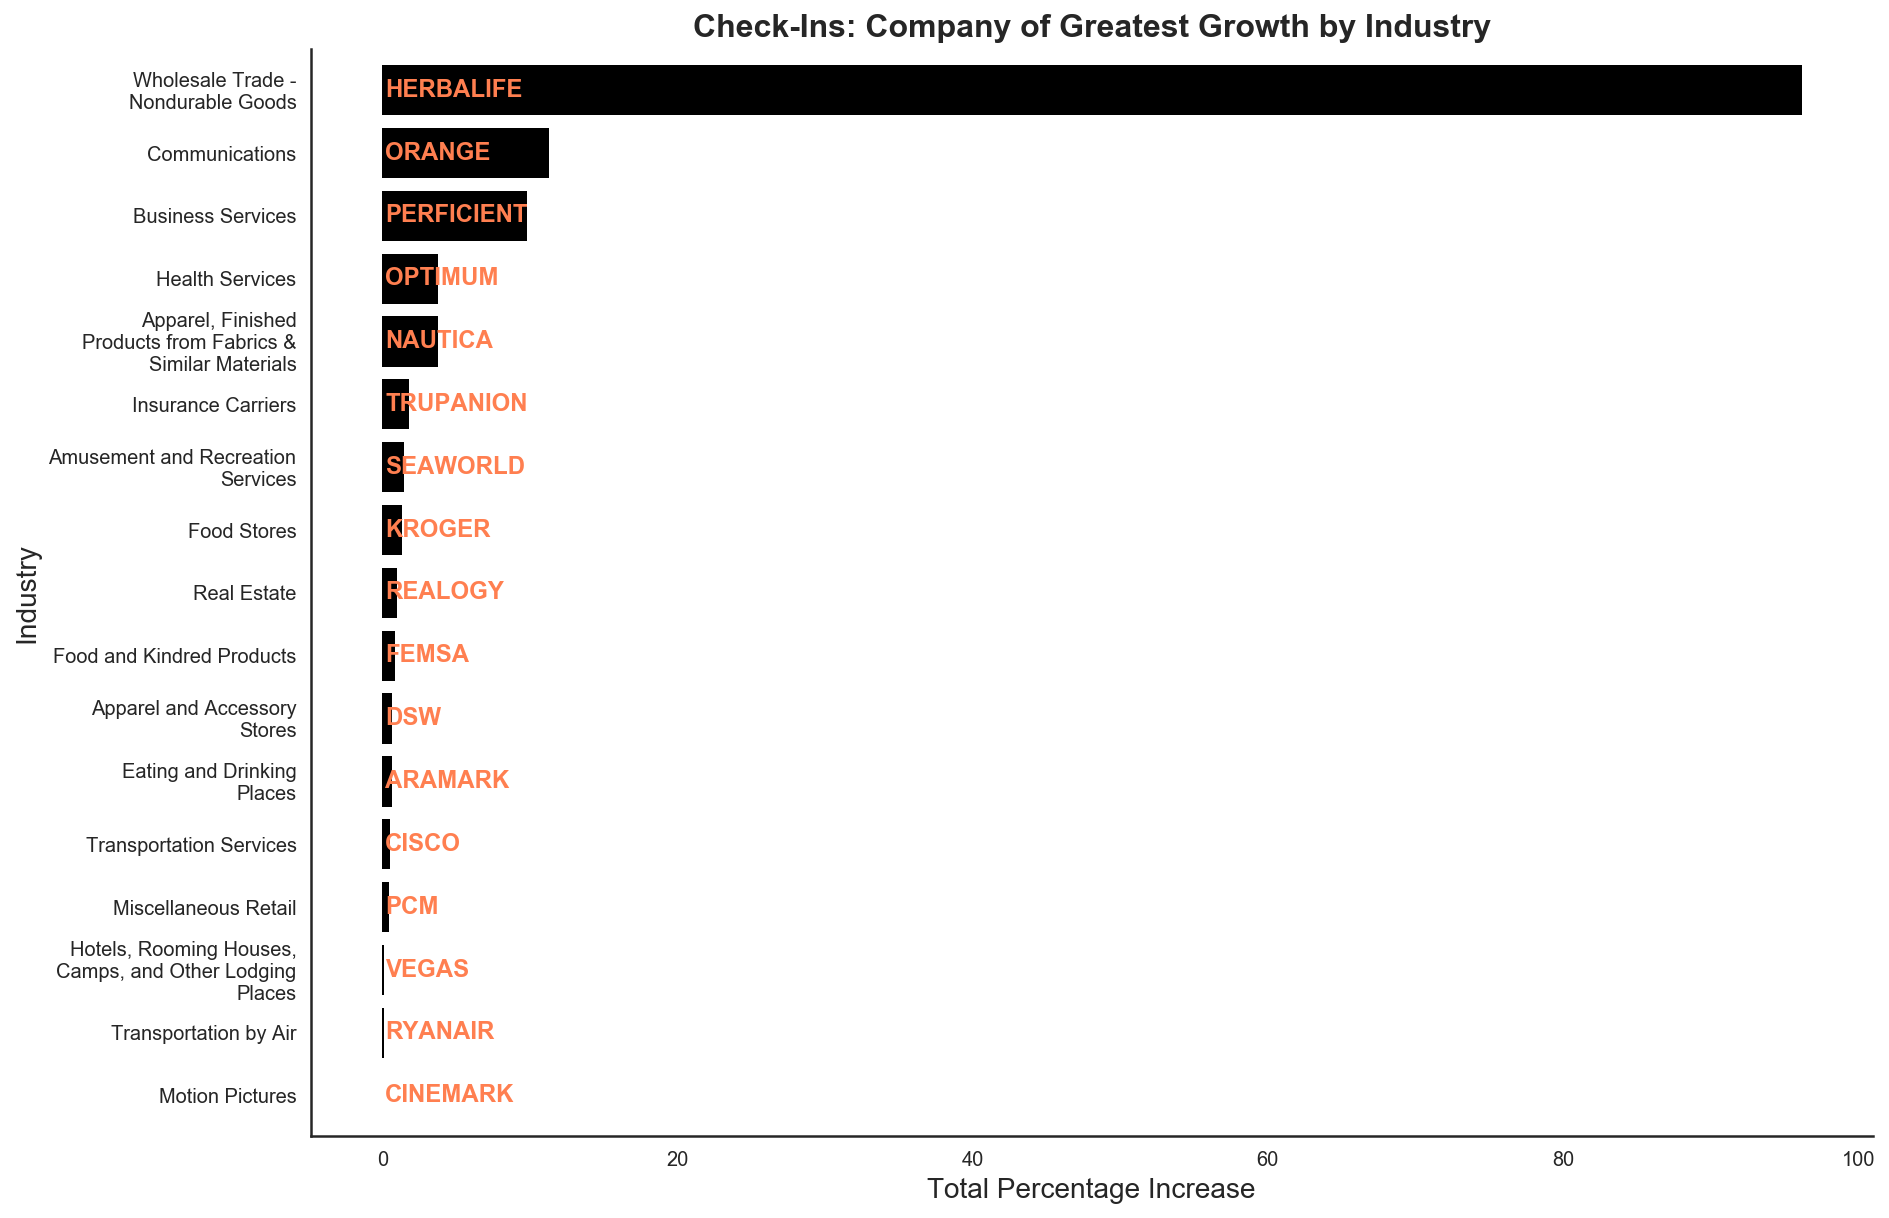

In [102]:
# visualization

bardata = df_inc_f['max'][::-1]
labels = df_inc_f['idxmax'][::-1].values.tolist()
yticks = df_inc_f.index[::-1].tolist()
yticks = [ '\n'.join(wrap(l, 25)) for l in  yticks]

fig, ax = plt.subplots(figsize=(14,10))
bardata.plot.barh(color = 'black', width = 0.8)
plt.title("Check-Ins: Company of Greatest Growth by Industry", fontsize = 16,fontweight='bold')
plt.ylabel("Industry", fontsize = 14)
plt.xlabel("Total Percentage Increase", fontsize = 14)

ax.set_yticklabels(yticks)

for i, v in enumerate(labels):
    plt.text(0.2,i, labels[i], color='coral', va='center', fontweight='bold')
sns.despine()

## Clustering
### Types of Different Companies in terms of their social media performance

In [234]:
def cluster(data, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    data: A Pandas DataFrame
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    
    # build the model
    model = KMeans(n_clusters = n_clusters, random_state = random_state)
    
    # fit our data
    model.fit(data)
    
    # obtain the predictions
    clusters = model.predict(data)
    
    return model, clusters

def plot_inertia(data, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    data: A Pandas DataFrame
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    # get the numbers of cluters 
    n_cl = list(range(start,end+1))
    
    # iniate an zeros for intertia values
    inertia = np.zeros(len(n_cl))
    
    # compute interia value for each model
    for idx, n in enumerate(n_cl):
        # get the model
        k_means, clusters = cluster(data, random_state = check_random_state(0), n_clusters = n)
        inertia[idx] = k_means.inertia_
        
    # make the plot
    
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(10,6))
    
    # draw the points 
    ax.set_xlim(1,10)
    plt.plot(n_cl, inertia)
    
    # add decorations
    ax.set_title("The elbow method")
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Inertia")
    sns.set(font_scale=1.5)

    return ax

def plot_pair(data, clusters, cols):
    '''
    Uses seaborn.PairGrid to visualize the data distribution
    when axes are the first four principal components.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    data: A numpy array. 
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    data = data[cols]
    data['clusters'] = clusters

    # make pair plot
    #fig, ax = plt.subplots(figsize=(20,20))
    sns.set(style="white")
    ax = sns.PairGrid(data, vars = cols, hue ="clusters")
    
    # plots on the diagonal are histograms 
    ax.map_diag(plt.hist)
    
    # plots off-diagonal are scatter plot
    ax.map_offdiag(plt.scatter)
    
    return ax

In [241]:
selected_features = [
       'checkins_cov', 'likes_cov',
       'talking_about_count_cov',
       'checkins_std',
       'were_here_count_std',
       'likes_std',
       'talking_about_count_std', 'checkins_inc',
       'likes_inc', 'talking_about_count_inc']

In [248]:
df_cls = df_notime[selected_features].replace([np.inf, -np.inf], np.nan)
df_cls.dropna(inplace=True)

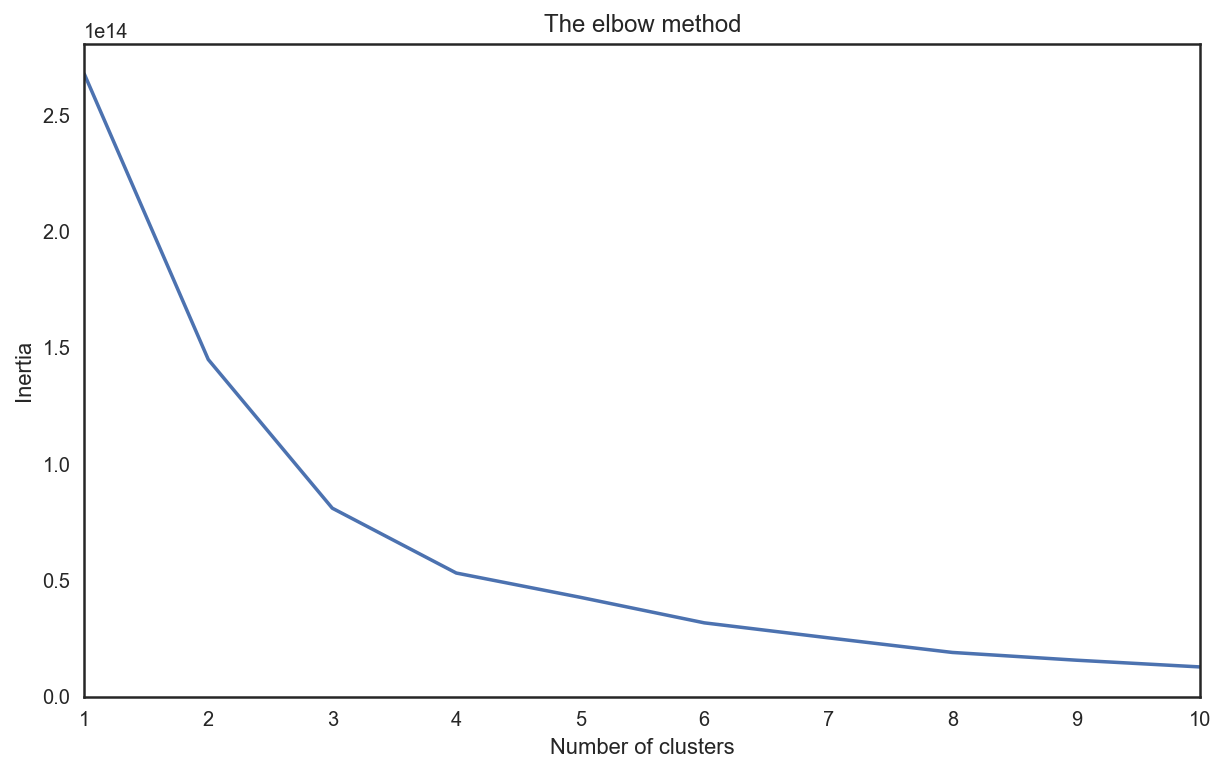

In [249]:
inertia = plot_inertia(df_cls)

In [250]:
k_means, clusters = cluster(df_cls, random_state=check_random_state(1), n_clusters=4)

In [251]:
df_cls['cluster'] = clusters

In [252]:
df_cls['cluster'].value_counts()

0    1933
1      13
3       7
2       3
Name: cluster, dtype: int64

/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


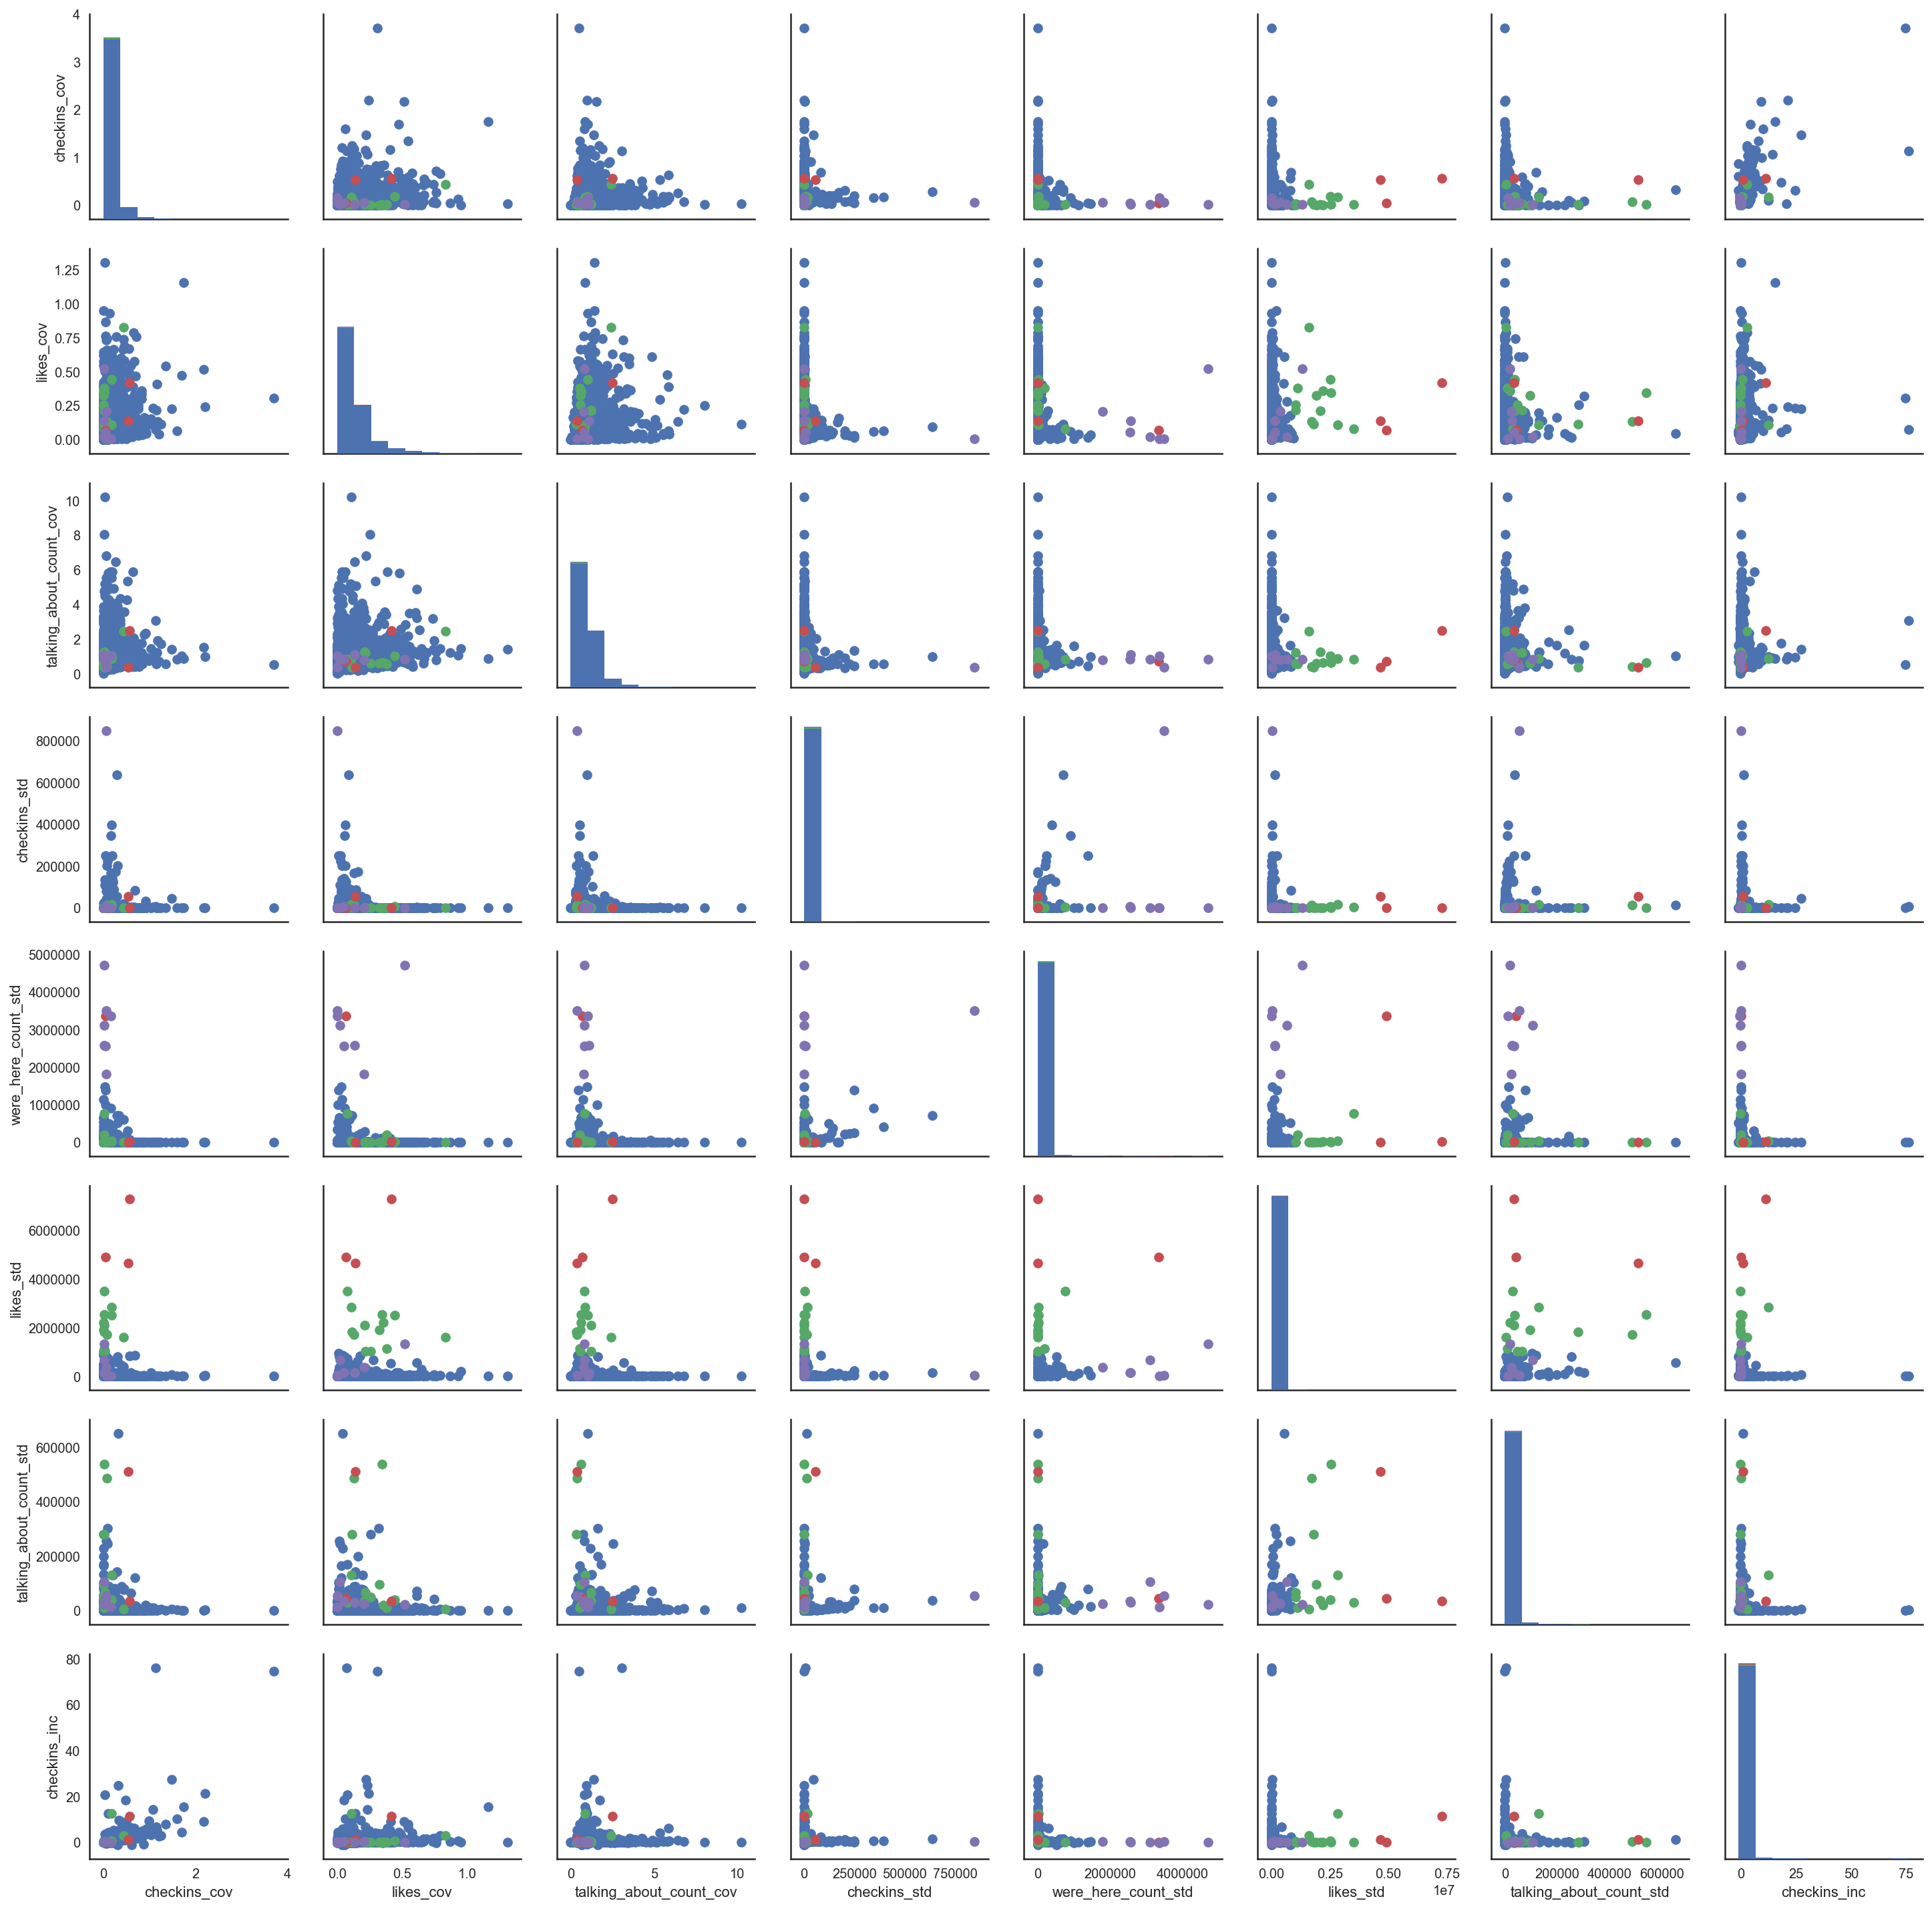

In [254]:
selected_cols = selected_features[0:8]
pg = plot_pair(df_cls, clusters, cols = selected_cols)

In [258]:
good = df_cls['cluster'] == 1
df_cls[good].index.tolist()

['LIGHTINTHEBOX',
 'NIKE',
 'FORD',
 'UNDERARMOUR',
 'WHOLEFOODS',
 'MICROSOFT',
 'ESPN',
 'TRIPADVISOR',
 'USATODAY',
 'MERCADOLIBRE',
 'NYTIMES',
 'KFC',
 'CASTROLUSA']

In [263]:
good = df_cls['cluster'] == 2
df_cls[good].index.tolist()

['ORANGE', 'WWE', 'MCDONALDSUS']

In [262]:
good = df_cls['cluster'] == 3
df_cls[good].index.tolist()

['WALMART',
 'DELTA',
 'CRACKERBARREL',
 'DENNYS',
 'TEXASROADHOUSE',
 'PLANETFITNESS',
 'DISNEYLAND']

### PCA Analysis

In [264]:
from sklearn.decomposition import PCA
pca = PCA()

# Fit model to the data
pca.fit(df_cls)

# We can print out rotation matrix and variance associated with each
# projected dimension

vars = pca.explained_variance_ratio_

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, selected_cols))
    print(output)

Variance:  Projected dimension
------------------------------
67.2%:     0.00 * checkins_cov +  0.00 * likes_cov + -0.00 * talking_about_count_cov +  0.01 * checkins_std +  0.34 * were_here_count_std +  0.94 * likes_std +  0.04 * talking_about_count_std +  0.00 * checkins_inc
31.5%:    -0.00 * checkins_cov + -0.00 * likes_cov + -0.00 * talking_about_count_cov +  0.05 * checkins_std +  0.94 * were_here_count_std + -0.34 * likes_std + -0.02 * talking_about_count_std + -0.00 * checkins_inc
 0.7%:    -0.00 * checkins_cov +  0.00 * likes_cov +  0.00 * talking_about_count_cov + -0.77 * checkins_std +  0.04 * were_here_count_std +  0.03 * likes_std + -0.63 * talking_about_count_std +  0.00 * checkins_inc
 0.6%:     0.00 * checkins_cov + -0.00 * likes_cov + -0.00 * talking_about_count_cov +  0.63 * checkins_std + -0.03 * were_here_count_std +  0.04 * likes_std + -0.77 * talking_about_count_std +  0.00 * checkins_inc
 0.0%:     0.00 * checkins_cov +  0.00 * likes_cov +  0.00 * talking_about_cou

In [265]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(df_cls)

In [266]:
pca_reduced = pd.DataFrame(data_reduced)

In [267]:
pca_reduced.columns = ['PC1','PC2']

In [268]:
pca_reduced['user'] = df_cls.index

In [269]:
pca_reduced.shape

(1956, 3)

In [271]:
pca_reduced['cluster'] = clusters

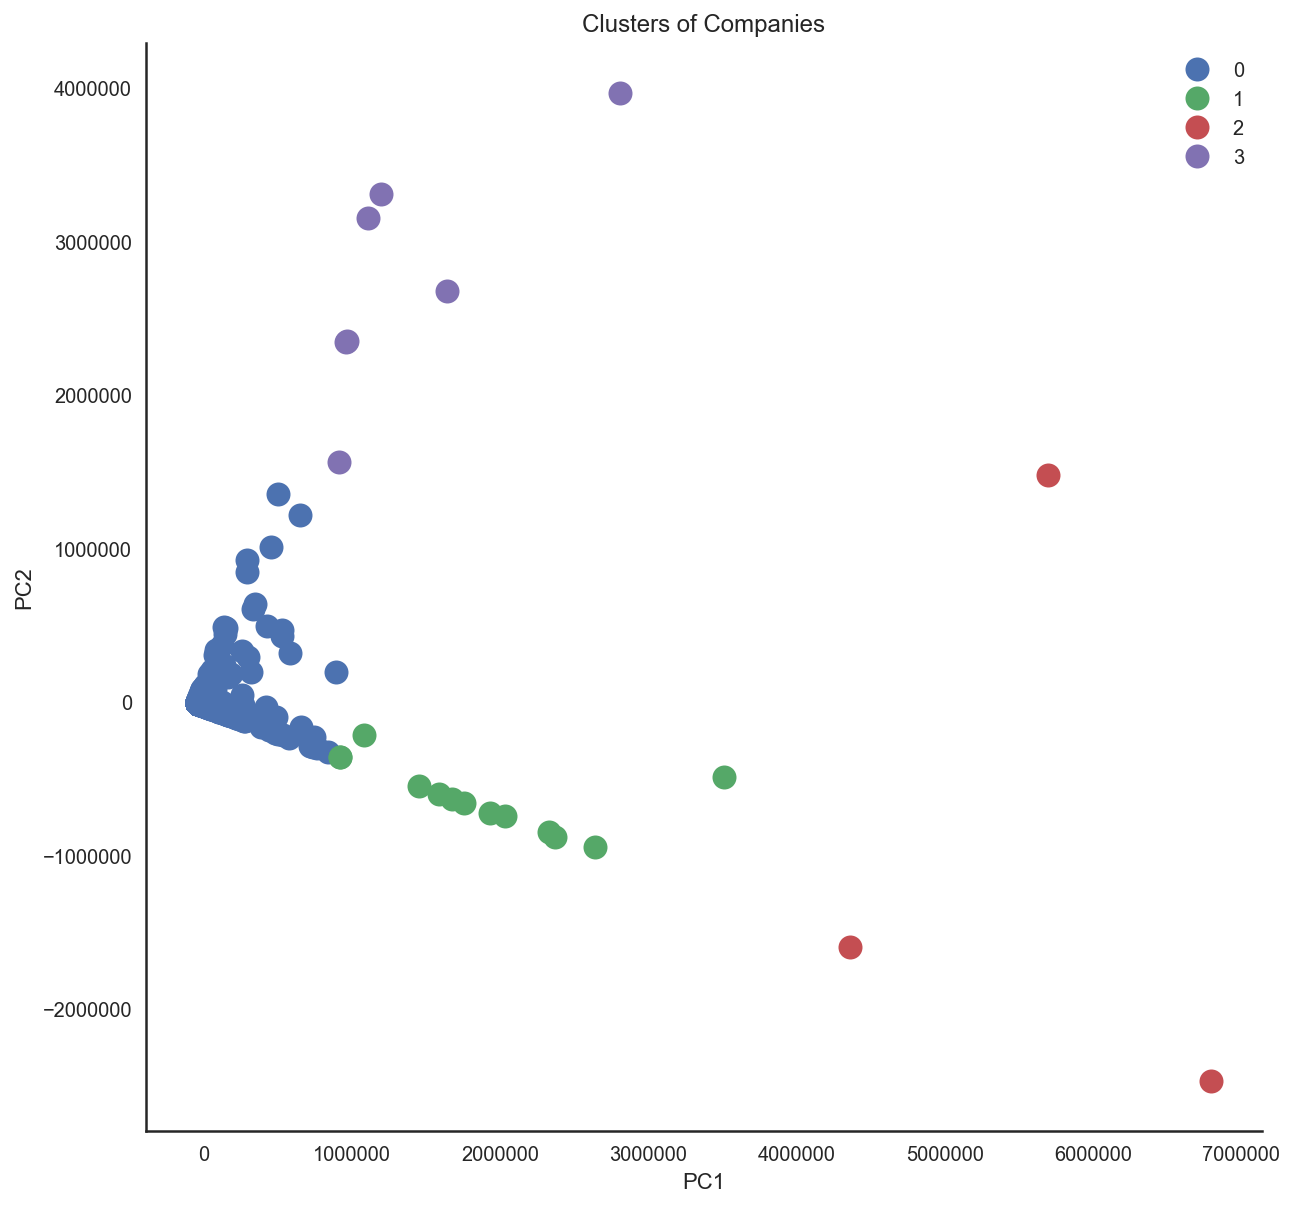

In [272]:
groups = pca_reduced.groupby(['cluster'])

# Plot
fig, ax = plt.subplots(figsize = (10,10))

for name, group in groups:
    ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=12, label=name)

ax.set_title("Clusters of Companies")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")    
ax.legend()
sns.despine()